# UE Computer Vision | Project : Visual tracking of video objects

pierre-henri.conze@imt-atlantique.fr

## Purpose of the project

Implement the methodology described in one of the two articles and apply it in the context of **visual tracking of video objects** within image sequences. Specifically, the targeted application consists in estimating for the whole sequence the location of a manually defined region of interest in the first image, called **reference image**. Development will be done in `python` programming language and can use functions from librairies such as `openCV`, `scikit-image`, `scikit-learn`, `keras`, `pytorch`...

In [1]:
import numpy as np
import cv2
from skimage import io, img_as_ubyte
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import distutils.dir_util
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel

## Data

You have 6 video sequences containing a **variable number of images** (from 26 to 196). You can evaluate your method with these videos and compare it with the approaches implemented by the other groups as well as the baseline provided below. The **training sequences** (`bag`, `bear`, `book`, `camel`, `rhino`, `swan`) are available on Moodle.

A binary mask is associated to each image to locate the object of interest (foreground object). Only one object of interest is targeted ! Except for the reference image, these **groundtruth masks** can only be used for the evaluation of the implemented method.

**Test sequences** will be provided at the end of the project.

In [2]:
name = 'swan' # name of the sequence : bag, bear, book, camel, rhino, swan
im_begin, im_end = 1, 26 # reference image (1) and last image (varies depending on the sequence)

Let us visualize some images with associated groundtruth masks.

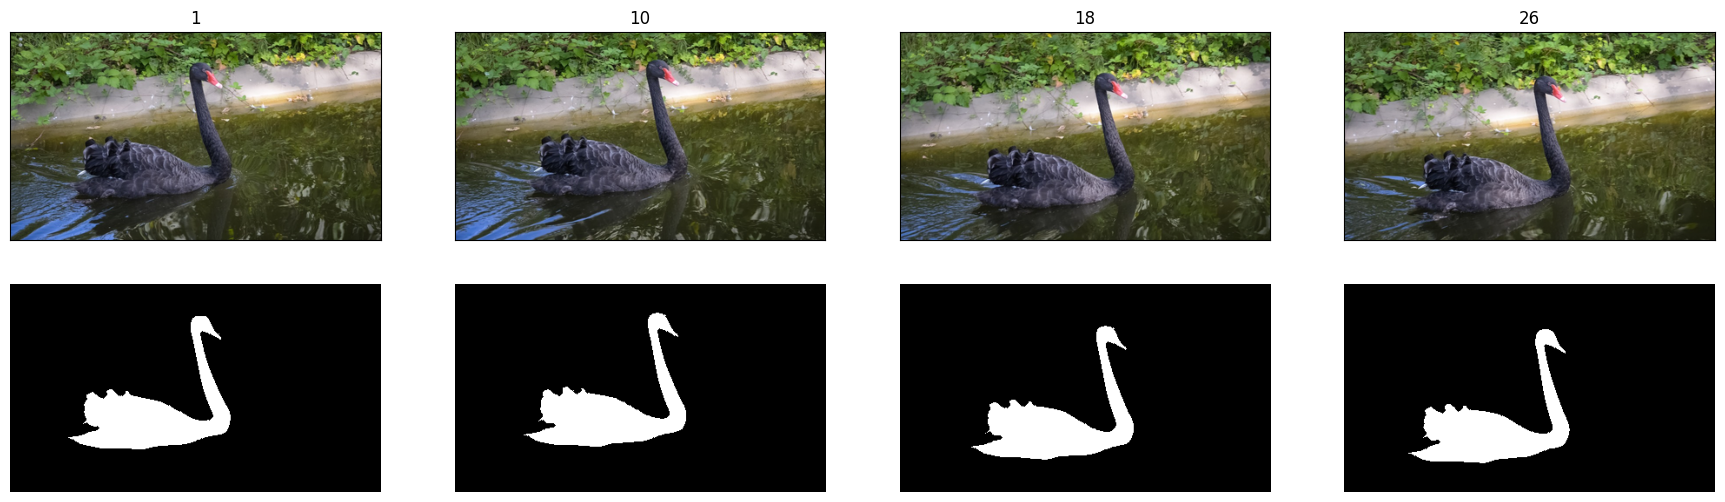

In [3]:
plt.figure(figsize=(22, 6))
for idx, im in enumerate([1,10,18,26]):
    img_current = io.imread(f"sequences/{name}/img/{name}"+'-%0*d.bmp'%(3,im))
    mask_current = io.imread(f"sequences-train/{name}"+'-%0*d.png'%(3,im))
    plt.subplot(2,4,idx+1), plt.title('%i' %(im)), plt.imshow(img_current), plt.xticks([]), plt.yticks([])
    plt.subplot(2,4,idx+5), plt.imshow(mask_current,cmap='gray'), plt.xticks([]), plt.yticks([])
    plt.axis('off')
plt.show()

## Assessment

The `dice_assessment()`, `db_eval_boundary()` and `centroid_assessment()` functions provided below will allow you to evaluate the implemented method. These functions take as inputs both groundtruth and estimated masks of the foreground object.

`dice_assessment()` evaluates the overlap between the two masks while `db_eval_boundary()` quantifies the quality of the estimated contours. Each function returns a score between 0% (poor quality) and 100% (perfect quality).

`centroid_assessment()` comptes the *Euclidean* distance between groundtruth and estimated centroids.

In [4]:
def dice_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0:
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [5]:
def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap

In [6]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

#  Baseline method

The **baseline** code below shows, as an indication, the implementation of a possible methodology (among others) to meet the project requirements.

Let us consider a sequence of $N$ RGB images $\{I_{n}\}$ with $n\in \{1,\ldots,N\}$ where $I_{1}$ is the so-called **reference image**. Here, we estimate the long term motion between each image $I_{n}$ with $n \neq 1$ and the reference image $I_{1}$ by means of an optical flow estimator which processes the pairs $\{I_{n},I_{1}\}$ independently.

In this example, an `openCV` implementation of the **Farnebäck's optical flow estimator** (G. Farnebäck, [Two-frame motion estimation based on polynomial expansion](https://link.springer.com/content/pdf/10.1007/3-540-45103-x_50.pdf), Image Analysis, pp. 363–370, 2003) is used.


In [7]:
def farneback(im1, im2):
    return cv2.calcOpticalFlowFarneback(im1, im2, None, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) # None

Once the optical flow fields have been estimated, the `propagate_mask() `function below can propagate the groundtruth segmentation mask from $I_{1}$ to $I_{n}$.

In [8]:
def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint8)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

In [9]:
img_begin = io.imread(f"sequences/{name}/img/{name}"+'-%0*d.bmp'%(3,im_begin))
mask_begin = io.imread(f"sequences-train/{name}"+'-%0*d.png'%(3,im_begin))

dices, fmeasures, centroid_dist, visu = [], [], [], []
for im in range(im_begin+1,im_end+1):
    # print(im) # debug
    img_current = io.imread(f"sequences/{name}/img/{name}"+'-%0*d.bmp'%(3,im))
    mask_current = io.imread(f"sequences-train/{name}"+'-%0*d.png'%(3,im))
    flow = farneback(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_begin)))
    propagation = propagate_mask(flow, img_current, mask_begin)
    # io.imsave(name+'-prop-%0*d.png'%(3,im), img_as_ubyte(propagation))
    visu.append(mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation, color=(1,0,0)))
    # io.imsave(name+'-bound-%0*d.png'%(3,im), img_as_ubyte(visu[-1]))
    dices.append(dice_assessment(mask_current, propagation))
    fmeasures.append(db_eval_boundary(mask_current, propagation))
    centroid_dist.append(centroid_assessment(mask_current, propagation))

## Results visualization

Once your method is implemented, you will be able to display the evolution of dice, F-measure scores and distance between centroids along the video sequences...

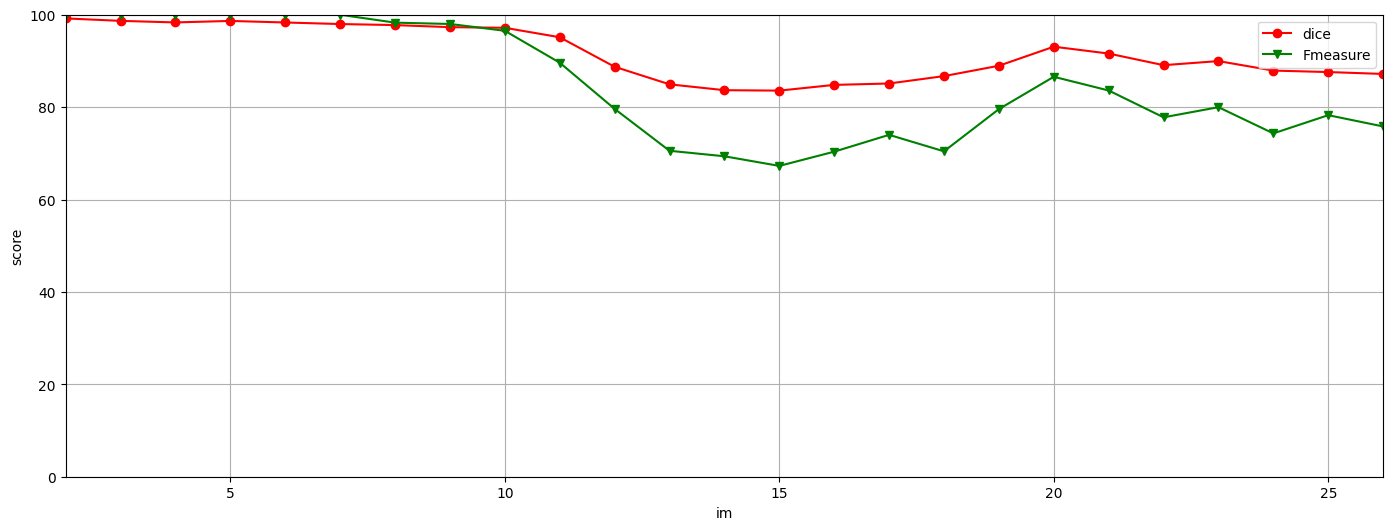

In [10]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,dices,marker='o',color='r')
plt.plot(x,fmeasures,marker='v',color='g')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'Fmeasure'])
# plt.savefig('eval.png')
plt.show()

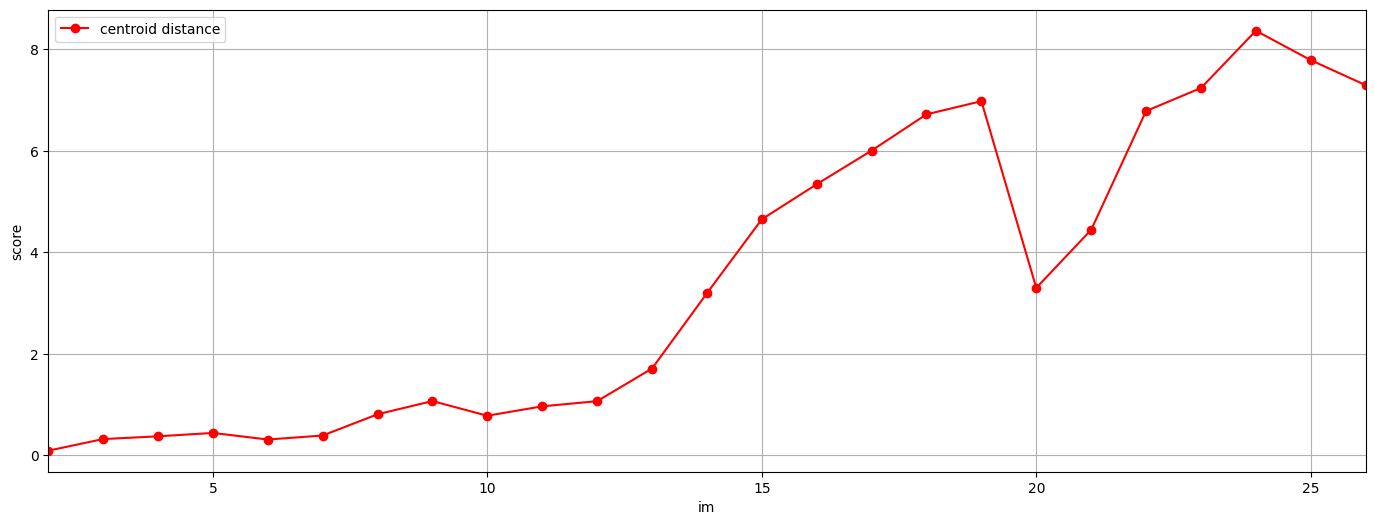

In [11]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,centroid_dist,marker='o',color='r')
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['centroid distance'])
# plt.savefig('eval-centroid.png')
plt.show()

... and view the obtained **tracking results** (ground truth in green, estimated contours in red) !

<Figure size 640x480 with 0 Axes>

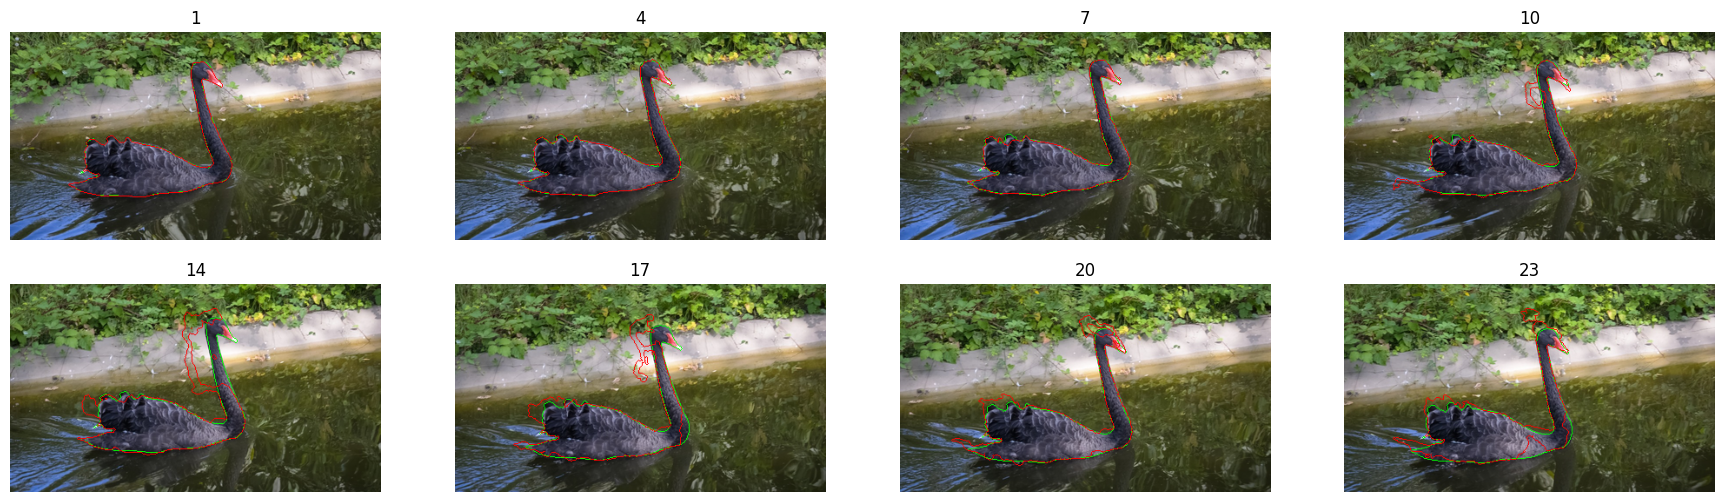

In [12]:
plt.figure()
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(visu[im])
    plt.title('%i' %(im+1))
plt.show()

#  GOTURN method

The following code is the implementation of the [GOTURN](https://github.com/davheld/GOTURN) methodology to meet the project requirements.

Let us consider a sequence of $N$ RGB images $\{I_{n}\}$ with $n\in \{1,\ldots,N\}$ where $I_{1}$ is the so-called **reference image**. Here, GOTURN is trying to track an object based on an input sequence of images and a starting image with groundtruth anotation. Then, it propagates the new location prediction from image $I_{n}$ to image $I_{n+1}$.

In [13]:
import math

def centroid_distance(groundtruth, estimate):
    x_gt, y_gt, w_gt, h_gt = groundtruth
    x_est, y_est, w_est, h_est = estimate

    # Computing centroids (center of the box)
    centroid_gt = (x_gt + w_gt / 2, y_gt + h_gt / 2)
    centroid_est = (x_est + w_est / 2, y_est + h_est / 2)

    # Calculating Euclidean distance between centroids
    distance = math.sqrt((centroid_gt[0] - centroid_est[0])**2 + (centroid_gt[1] - centroid_est[1])**2)
    return distance

Running Goturn with normal images
Save directory pygoturn/result already exists pygoturn/result
Mean IoU:  0.672960556126334


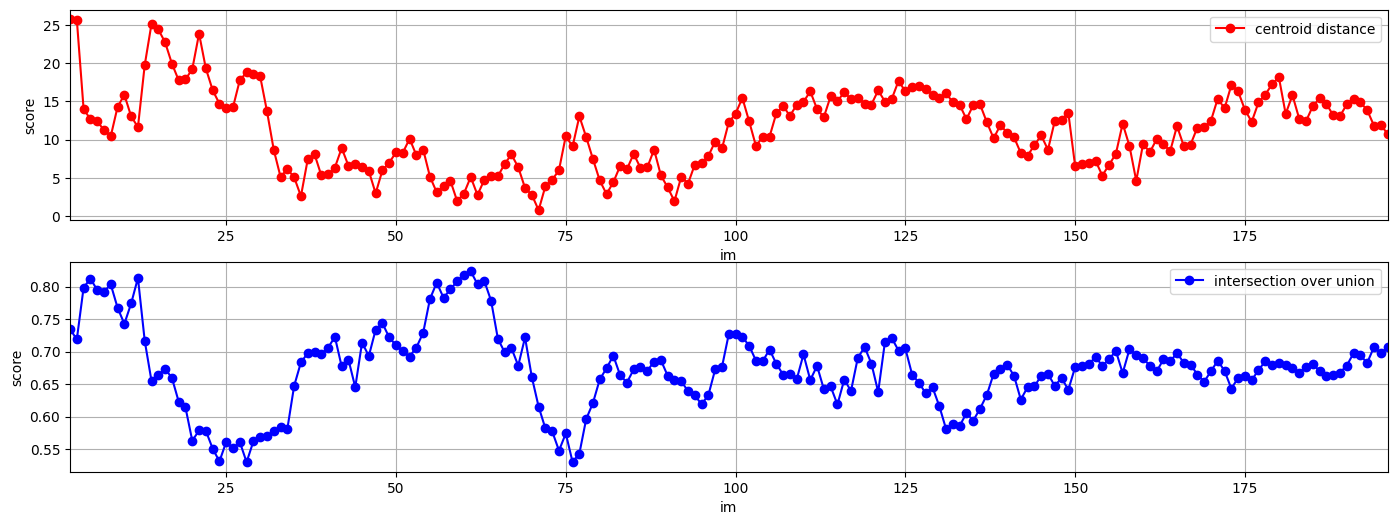

In [39]:
import os
import argparse

import torch
import cv2

import sys
sys.path.append('pygoturn/src/')
from test import GOTURN

def axis_aligned_iou(boxA, boxB):
    # make sure that x1,y1,x2,y2 of a box are valid
    assert(boxA[0] <= boxA[2])
    assert(boxA[1] <= boxA[3])
    assert(boxB[0] <= boxB[2])
    assert(boxB[1] <= boxB[3])

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def save(im, bb, gt_bb, idx):
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    bb = [int(val) for val in bb]  # GOTURN output
    gt_bb = [int(val) for val in gt_bb]  # groundtruth box
    # plot GOTURN predictions with red rectangle
    im = cv2.rectangle(im, (bb[0], bb[1]), (bb[2], bb[3]),
                       (0, 0, 255), 2)
    # plot annotations with white rectangle
    im = cv2.rectangle(im, (gt_bb[0], gt_bb[1]), (gt_bb[2], gt_bb[3]),
                       (255, 255, 255), 2)
    save_path = os.path.join(save_dir, str(idx)+'.jpg')
    cv2.imwrite(save_path, im)

def main(pretrained_model, data, save_dir, processed):
    centroid_dist = []
    IoUs          = []
    seq = data[10:]
    
    cuda    = torch.cuda.is_available()
    device  = torch.device('cuda:0' if cuda else 'cpu')
    tester  = GOTURN(data,
                    pretrained_model,
                    device, processed)
    
    if os.path.exists(save_dir):
        print('Save directory %s already exists' % (save_dir), save_dir)
    else:
        os.makedirs(save_dir)
        
    # save initial frame with bounding box
    save(tester.img[0][0], tester.prev_rect, tester.prev_rect, 1)
    tester.model.eval()

    # loop through sequence images
    for i in range(tester.len):
        # get torch input tensor
        sample = tester[i]

        # predict box
        bb      = tester.get_rect(sample)
        gt_bb   = tester.gt[i]
        tester.prev_rect = bb
        centroid_dist.append(centroid_distance(bb, gt_bb))
        
        # save current image with predicted rectangle and gt box
        im = tester.img[i][1]
        save(im, bb, gt_bb, i+2)
        
        IoUs.append(axis_aligned_iou(gt_bb, bb))

        # print stats
        # print('frame: %d, IoU = %f' % (
        #     i+2, axis_aligned_iou(gt_bb, bb)))
    
    # Saving centroid distance .npy file
    np.save(f"team6-{seq}-centroid-distances.npy", centroid_dist)
    
    print("Mean IoU: ", np.mean(np.array(IoUs)))
    return centroid_dist, IoUs


if __name__ == "__main__":
    
    seq                 = 'bag'
    im_begin, im_end    = 1, 196
    pretrained_model    = '/Users/edabier/Documents/IMT/Computer_Vision/projet/pygoturn/pytorch_goturn.pth.tar'
    data                = f'sequences/{seq}'
    save_dir            = 'pygoturn/result'
    processed           = False
    
    if processed:
        img_begin = io.imread(f"sequences/{seq}/processed_img/processed_{seq}"+'-%0*d.bmp'%(3,im_begin))
        mask_begin = io.imread(f"sequences-train/{seq}"+'-%0*d.png'%(3,im_begin))  
    else:
        img_begin = io.imread(f"sequences/{seq}/img/{seq}"+'-%0*d.bmp'%(3,im_begin))
        mask_begin = io.imread(f"sequences-train/{seq}"+'-%0*d.png'%(3,im_begin)) 
        
    # axs[1].imshow(img_begin)
    centroid_dist, IoUs = main(pretrained_model, data, save_dir, processed)
    
    fig, axs = plt.subplots(2, figsize=(17, 6))
    x = range(im_begin+1,im_end+1)
    axs[0].plot(x, centroid_dist,marker='o',color='r')
    axs[0].set_xlim((im_begin+1,im_end))
    axs[0].set_ylabel('score')
    axs[0].set_xlabel("im")
    axs[0].grid()
    axs[0].legend(['centroid distance'])
    
    # axs[1].figure(figsize=(17, 6))
    axs[1].plot(x, IoUs,marker='o',color='b')
    axs[1].set_xlim((im_begin+1,im_end))
    axs[1].set_ylabel('score')
    axs[1].set_xlabel("im")
    axs[1].grid()
    axs[1].legend(['intersection over union'])
    # plt.savefig('occluded-bear-sequence.png')
    plt.show()

- Make it predict several boxes with randomness
- Add segmentation 